# Binary Classification Example: Bank Note Dataset

In [137]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.metrics
import numpy.random as rng
import matplotlib.pyplot as plt

In [138]:
df = pd.read_csv("data/data_banknote_authentication.txt", sep=",", header=None)
df

,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [140]:
df.corr(method='spearman')

,0,1,2,3,4
0,1.000000,0.255126,-0.326704,0.241503,-0.735605
1,0.255126,1.000000,-0.729426,-0.572510,-0.429016
2,-0.326704,-0.729426,1.000000,0.433299,0.061600
3,0.241503,-0.572510,0.433299,1.000000,-0.032751
4,-0.735605,-0.429016,0.061600,-0.032751,1.000000


In [141]:
df.corr(method='pearson')

,0,1,2,3,4
0,1.000000,0.264026,-0.380850,0.276817,-0.724843
1,0.264026,1.000000,-0.786895,-0.526321,-0.444688
2,-0.380850,-0.786895,1.000000,0.318841,0.155883
3,0.276817,-0.526321,0.318841,1.000000,-0.023424
4,-0.724843,-0.444688,0.155883,-0.023424,1.000000


Text(0.5, 1.0, 'Inauthentic')

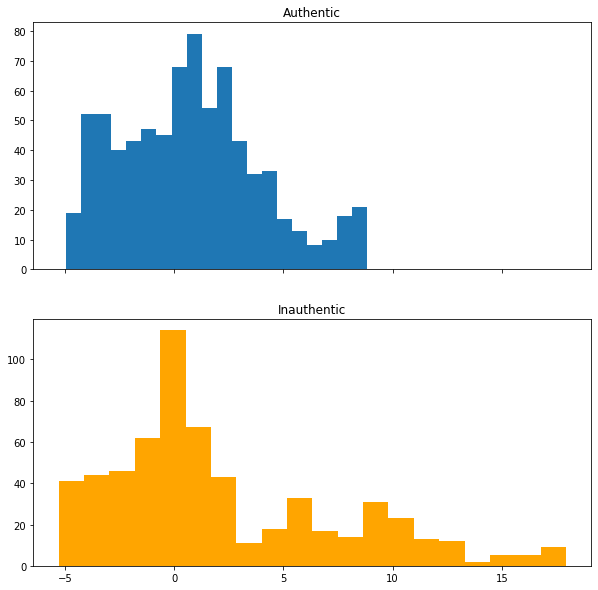

In [143]:
col = 2

authentic_notes_ix = df[4] == 0
feature_values = df[authentic_notes_ix][col]

f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axes[0].hist(feature_values, bins=20)
axes[0].set_title('Authentic')

inauthentic_notes_ix = df[4] == 1
feature_values = df[inauthentic_notes_ix][col]
axes[1].hist(feature_values, bins=20, color='orange')
axes[1].set_title('Inauthentic')

In [175]:
X = np.array(df[[0,1]])
y = np.array(df[[4]]) ## doing [[4]] is important!!!

In [176]:
muX = np.mean(X, axis=0)
print(muX)
stdX = np.std(X, axis=0)
print(stdX)
Z = (X - muX) / stdX
print(Z)
print(np.mean(Z, axis=0))
print(np.std(Z, axis=0))

[0.43373526 1.92235312]
[2.84172641 5.86690749]
[[ 1.12180565  1.14945512]
 [ 1.44706568  1.06445293]
 [ 1.20780971 -0.77735215]
 ...
 [-1.47235682 -2.62164576]
 [-1.40669251 -1.75647104]
 [-1.04712236 -0.43982168]]
[0.00000000e+00 4.14310633e-17]
[1. 1.]


In [178]:
# try varying the number of hidden units
n_hidden = 10
eta = 0.1

# move data to tensorflow space
Z = tf.convert_to_tensor(Z, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(Z.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

# repeat N times
N = 100
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(Z, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
       
        # loss
        xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
        
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(Z, W_input_hidden))
pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
print("Final XE: %0.4f" % xe_loss.numpy())

# report results
pi = pi.numpy()
pred_1 = pi > 0.5
acc = np.mean(y.numpy() == pred_1)
print("Accuracy: %0.2f" % acc)

auc_roc = sklearn.metrics.roc_auc_score(y, pi)
print("AUC-ROC: %0.2f" % auc_roc)


Final XE: 0.1474
Accuracy: 0.93
AUC-ROC: 0.99


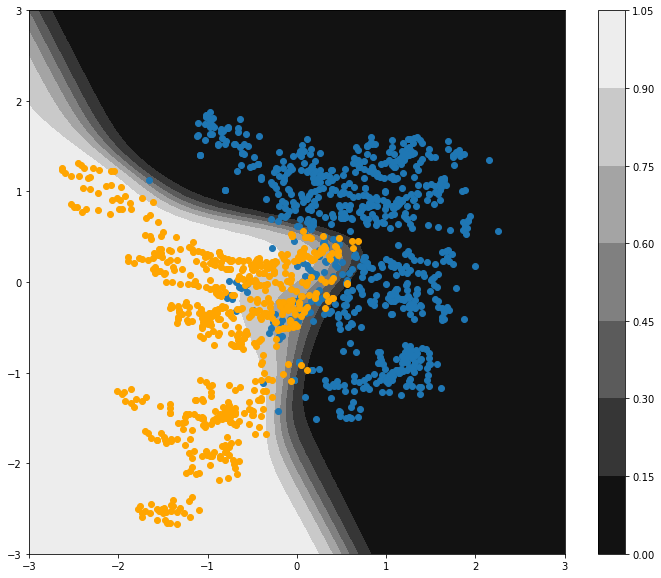

In [198]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

class0_ix = y[:,0] == 0
class1_ix = y[:,0]== 1

Z_np = Z.numpy()

# initialize range of input values
K = 100
xs = np.linspace(-3, 3, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T
Xstar = tf.convert_to_tensor(Xstar, dtype=tf.float32)

# predict
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xstar, W_input_hidden))
pi_star = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))

# plot
pi_star = pi_star.numpy().reshape((K, K))
cp = ax.contourf(x1s, x2s, pi_star, cmap=plt.get_cmap('gist_gray'))
f.colorbar(cp)


ax.scatter(Z_np[class0_ix, 0], Z_np[class0_ix, 1])
ax.scatter(Z_np[class1_ix, 0], Z_np[class1_ix, 1], color='orange')
